In [1]:
# Improt the necessary libraries
import itertools
import xarray as xr
import rasterio
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import numpy as np
from ai4ebv.core import landcover

In [2]:
# Filepaths

WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"
WTE_GLOBAL = "WTE1778.tif"

# Wte table

WTE_TABLE = WTE_FOLDER + "Tables/Realm_WE_attribute_Table_DraftSort.csv"

# South Tyrol shapefile

ST_SHP = "/mnt/drive/AI4EBV/BOUNDARIES/ST.shp"

# Output desired UTM Projection
# It is estimated automatically based on the provided shapefile. Needs to be tested in details. New PROJ version required >7
OUTPUT_CRS = "EPSG:32632"

Read the input WTE layer

In [3]:
wte_global = xr.open_rasterio(WTE_FOLDER + WTE_GLOBAL)
wte_global

<xarray.DataArray (band: 1, y: 3535, x: 6358)>
[22475530 values with dtype=uint32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 50.1 50.1 50.1 50.1 50.1 ... 42.17 42.17 42.17 42.17
  * x        (x) float64 3.643 3.645 3.647 3.649 ... 17.91 17.91 17.92 17.92
Attributes:
    transform:      (0.0022457989999999997, 0.0, 3.64154024832649, 0.0, -0.00...
    crs:            +init=epsg:4326
    res:            (0.0022457989999999997, 0.0022457989999999997)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic

Read the input shapefile

In [4]:
df = gpd.read_file(ST_SHP)
df

,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,4,21,BOLZANO/BOZEN,664283.497457,7.397682e+09,"POLYGON ((743472.190 5219940.300, 743499.120 5..."


In [5]:
df4326 = df.to_crs(4326)

In [6]:
df_buffer = df4326.copy()

In [7]:
delta = 0.1
minX = df_buffer.geometry.bounds['minx'] - delta
minY = df_buffer.geometry.bounds['miny'] - delta
maxX = df_buffer.geometry.bounds['maxx'] + delta
maxY = df_buffer.geometry.bounds['maxy'] + delta

In [8]:
wte_table = pd.read_csv(WTE_TABLE, sep=';')
wte_table

,RealmWE_ID,WE_ID,Realm_ID,RealmClass,LF_Class,MoistClass,TempClass,LC_Class,Realm_Name,LF_Name,LC_Name,Temp_Name,Moist_Name,Temp_Moist,WEcosystm,RWEcosystm,LandC_Type,Code
0,1005,5,1000,1,1,3,6,6,Afrotropic,Mountains,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Mount...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6316
1,1010,10,1000,1,3,3,6,6,Afrotropic,Tablelands,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Table...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6336
2,1016,16,1000,1,2,3,6,6,Afrotropic,Hills,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Hills,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6326
3,1018,18,1000,1,1,3,6,4,Afrotropic,Mountains,Grassland,Polar,Moist,Polar Moist,Polar Moist Grassland on Mountains,Afrotropic Polar Moist Grassland on Mountains,Natural,6314
4,1024,24,1000,1,3,3,6,2,Afrotropic,Tablelands,Shrubland,Polar,Moist,Polar Moist,Polar Moist Shrubland on Tablelands,Afrotropic Polar Moist Shrubland on Tablelands,Natural,6332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,8399,399,8000,8,1,3,3,8,Palearctic,Mountains,Snow and Ice,Warm Temperate,Moist,Warm Temperate Moist,Warm Temperate Moist Snow and Ice on Mountains,Palearctic Warm Temperate Moist Snow and Ice o...,Natural,3318
1777,8400,400,8000,8,3,1,4,3,Palearctic,Tablelands,Forest,Sub Tropical,Desert,Sub Tropical Desert,Sub Tropical Desert Forest on Tablelands,Palearctic Sub Tropical Desert Forest on Table...,Natural,4133
1778,8406,406,8000,8,2,1,5,3,Palearctic,Hills,Forest,Tropical,Desert,Tropical Desert,Tropical Desert Forest on Hills,Palearctic Tropical Desert Forest on Hills,Natural,5123
1779,8412,412,8000,8,3,1,5,2,Palearctic,Tablelands,Shrubland,Tropical,Desert,Tropical Desert,Tropical Desert Shrubland on Tablelands,Palearctic Tropical Desert Shrubland on Tablel...,Natural,5132


# Landcover

## WTE Landcover Layer

In [9]:
wte_clipped = wte_global.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
max_value = wte_clipped.max().values
while(max_value>8):
    LFValue = wte_table.loc[wte_table['RealmWE_ID']==max_value]['LC_Class']
    if len(LFValue) != 0:
        wte_clipped = wte_clipped.where(wte_clipped!=max_value).fillna(int(LFValue))
    else:
        break
    max_value = wte_clipped.max().values
wte_clipped = wte_clipped.where(wte_clipped!=wte_clipped.attrs["_FillValue"])
wte_clipped.attrs["_FillValue"] = np.nan

Define colors and labels for plotting:

In [10]:
landcover_colors = {'Cropland':"#FFFF64",'Shrubland':"#966400",'Forest':"#00A000",'Grassland':"#FFB432",'Settlement':"#C31400",'Bare Areas':"#FFEBAF",'Surface Water':"#BEE8FF",'Snow and Ice':"#FFFFFF"}
landcovers     = ['Cropland','Shrubland','Forest','Grassland','Settlement','Bare Areas','Surface Water','Snow and Ice']

legend = []
for i,x in enumerate(landcovers):
    color = landcover_colors[x]
    legend.append(mpatches.Patch(color=color,label=x))

Create cmap for landcover layer

In [11]:
cmap_landcover = ListedColormap(["#FFFF64","#966400","#00A000","#FFB432","#C31400","#FFEBAF","#BEE8FF","#FFFFFF"])

Reproject to the desired UTM projection:

In [12]:
#wte_lc_UTM = wte_clipped.rio.reproject(OUTPUT_CRS,resolution=250, resampling=6) # Majority - Mode
wte_lc_UTM = wte_clipped.rio.reproject(wte_clipped.rio.estimate_utm_crs(),resolution=250, resampling=6) # New Proj required
wte_lc_UTM = wte_lc_UTM.rio.clip(df.geometry, drop=True)

[]

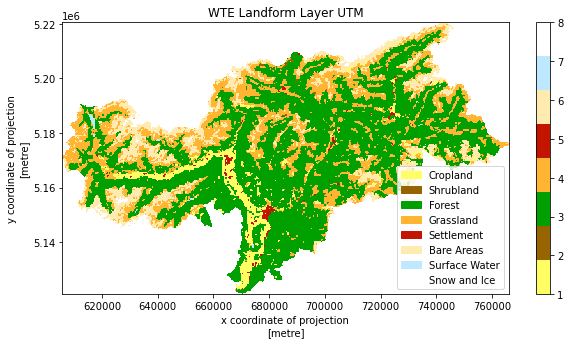

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_lc_UTM[0].plot.imshow(ax=ax,cmap=cmap_landcover,vmax=8, vmin=1)
ax.set_title("WTE Landform Layer UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [14]:
# wte_lc_UTM[0].to_netcdf("wte_lc_UTM_ST.nc")

## Copernicus Global Land cover

In [15]:
LANDCOVER_FOLDER = "/mnt/drive/AI4EBV/INPUTS/LANDCOVER/"
WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"

CGLC   = LANDCOVER_FOLDER + "COPERNICUS_GLOBAL_LC/E000N60_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif"

In [16]:
# Globeland30	LISS 

In [17]:
cglc_landcover = xr.open_rasterio(CGLC)
cglc_landcover

<xarray.DataArray (band: 1, y: 20160, x: 20160)>
[406425600 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 60.0 60.0 60.0 60.0 60.0 ... 40.0 40.0 40.0 40.0 40.0
  * x        (x) float64 0.000496 0.001488 0.00248 0.003472 ... 20.0 20.0 20.0
Attributes: (12/36)
    transform:                    (0.0009920634920634888, 0.0, 0.0, 0.0, -0.0...
    crs:                          +init=epsg:4326
    res:                          (0.0009920634920634888, 0.0009920634920634888)
    is_tiled:                     1
    nodatavals:                   (255.0,)
    scales:                       (1.0,)
    ...                           ...
    sensor:                       VEGETATION
    source:                       Derived from EO satellite imagery
    time_coverage_end:            2016-12-31T23:59:59Z
    time_coverage_start:          2014-01-01T00:00:00Z
    time_reference_year:          2015
    title:                        Dynamic Land Cover Map 100m 2015-base

In [18]:
df4326 = df.to_crs(4326)

In [19]:
cglc_landcover_clipped = cglc_landcover.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY).astype(float)
cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=cglc_landcover_clipped.attrs["_FillValue"])
cglc_landcover_clipped.attrs["_FillValue"] = np.nan

Classify CGIC Landcover to WTE scheme

In [20]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(cglc_landcover_clipped))
max_value = int(cglc_landcover_clipped.max().values)
while(max_value>8):
    if max_value==255:
        lcValue = np.nan
        cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=max_value).fillna(lcValue)
        max_value = int(cglc_landcover_clipped.max().values)
    elif max_value!=255:
        lcValue = landcover.Copernicus2Wte[max_value]
        cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=max_value).fillna(lcValue)
        max_value = int(cglc_landcover_clipped.max().values)
    else:
        break

cglc_landcover_clipped = cglc_landcover_clipped.where(na_mask)

Reprojection to 250m in UTM with mode interpolation

In [21]:
cglc_landcover_clipped = cglc_landcover_clipped.rio.reproject_match(wte_lc_UTM,6)
cglc_landcover_clipped = cglc_landcover_clipped.rio.clip(df.geometry, drop=True)
cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=cglc_landcover_clipped.attrs["_FillValue"])
cglc_landcover_clipped.attrs["_FillValue"] = np.nan

[]

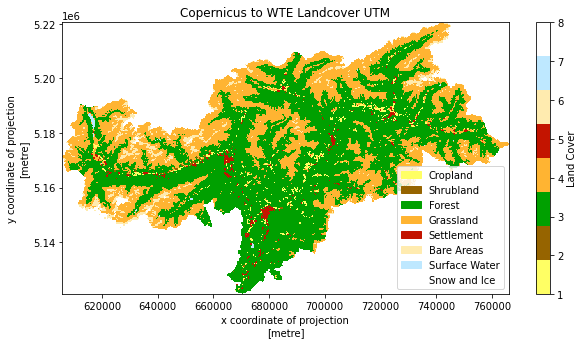

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
fig = cglc_landcover_clipped[0].plot.imshow(ax=ax,cmap=cmap_landcover,vmax=8, vmin=1)
ax.set_title("Copernicus to WTE Landcover UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [23]:
# cglc_landcover_clipped[0].to_netcdf("cglc_lc_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [24]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lc_UTM),xr.ufuncs.isnan(cglc_landcover_clipped)))
wte_lc_UTM_masked_cglc = wte_lc_UTM.where(na_mask)
cglc_to_wte_UTM_masked = cglc_landcover_clipped.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [25]:
wte_cglc_diff = wte_lc_UTM_masked_cglc - cglc_to_wte_UTM_masked

[]

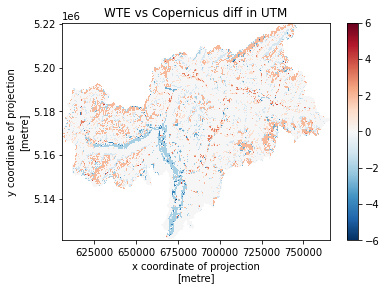

In [26]:
fig, ax = plt.subplots()
wte_cglc_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs Copernicus diff in UTM")
plt.plot()

## GLOBELAND30

In [27]:
GLOBELAND30  = LANDCOVER_FOLDER + "GLOBELAND/GLOBELAND_2020_ALPS.tif"

In [28]:
globeland_landcover = xr.open_rasterio(GLOBELAND30)
globeland_landcover

<xarray.DataArray (band: 1, y: 41186, x: 48481)>
[1996738466 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.66e+06 5.66e+06 5.66e+06 ... 4.424e+06 4.424e+06
  * x        (x) float64 2.364e+05 2.364e+05 2.364e+05 ... 1.691e+06 1.691e+06
Attributes:
    transform:               (30.0, 0.0, 236357.6132549128, 0.0, -30.0, 56596...
    crs:                     +init=epsg:32631
    res:                     (30.0, 30.0)
    is_tiled:                1
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [29]:
df32631 = df.to_crs(32631)

In [30]:
df_buffer = df32631.copy()

In [31]:
delta = 10000
minX = df_buffer.geometry.bounds['minx'] - delta
minY = df_buffer.geometry.bounds['miny'] - delta
maxX = df_buffer.geometry.bounds['maxx'] + delta
maxY = df_buffer.geometry.bounds['maxy'] + delta

In [33]:
globeland_lc_clipped = globeland_landcover.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY).astype(float)
globeland_lc_clipped = globeland_lc_clipped.where(globeland_lc_clipped!=globeland_lc_clipped.attrs["_FillValue"])
globeland_lc_clipped.attrs["_FillValue"] = np.nan

In [34]:
globeland_lc_clipped = globeland_lc_clipped.where(globeland_lc_clipped>0)

Classify Globeland Landcover to WTE scheme

In [35]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(globeland_lc_clipped))
max_value = int(globeland_lc_clipped.max().values)
while(max_value>8):
    if max_value==255:
        lcValue = np.nan
        globeland_lc_clipped = globeland_lc_clipped.where(globeland_lc_clipped!=max_value).fillna(lcValue)
        max_value = int(globeland_lc_clipped.max().values)
    elif max_value!=255:
        lcValue = landcover.Globeland2Wte[max_value]
        globeland_lc_clipped = globeland_lc_clipped.where(globeland_lc_clipped!=max_value).fillna(lcValue)
        max_value = int(globeland_lc_clipped.max().values)
    else:
        break

globeland_lc_clipped = globeland_lc_clipped.where(na_mask)

Reprojection to 250m in UTM with mode interpolation

In [36]:
globeland_lc_clipped = globeland_lc_clipped.rio.reproject_match(wte_lc_UTM,6)
globeland_lc_clipped = globeland_lc_clipped.rio.clip(df.geometry, drop=True)
globeland_lc_clipped = globeland_lc_clipped.where(globeland_lc_clipped!=globeland_lc_clipped.attrs["_FillValue"])
globeland_lc_clipped.attrs["_FillValue"] = np.nan

[]

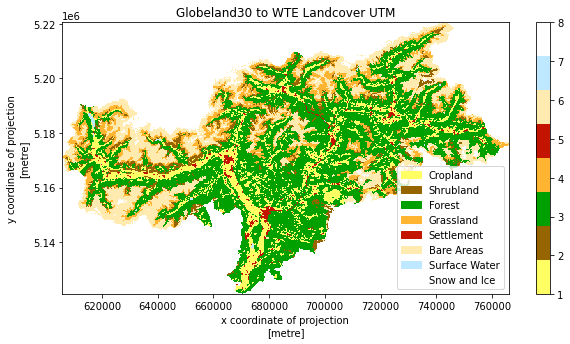

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
fig = globeland_lc_clipped[0].plot.imshow(ax=ax,cmap=cmap_landcover,vmax=8, vmin=1)
ax.set_title("Globeland30 to WTE Landcover UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [38]:
# globeland_lc_clipped[0].to_netcdf("globeland_lc_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [39]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lc_UTM),xr.ufuncs.isnan(globeland_lc_clipped)))
wte_lc_UTM_masked_globeland = wte_lc_UTM.where(na_mask)
globeland_to_wte_UTM_masked = globeland_lc_clipped.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [40]:
wte_globeland_diff = wte_lc_UTM_masked_globeland - globeland_to_wte_UTM_masked

[]

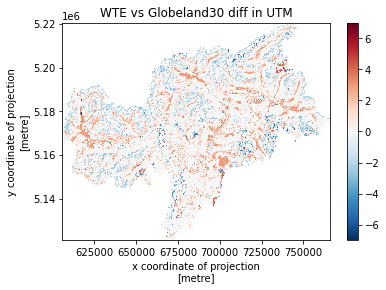

In [41]:
fig, ax = plt.subplots()
wte_globeland_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs Globeland30 diff in UTM")
plt.plot()

## LISS

In [42]:
LISS  = LANDCOVER_FOLDER + "LISS/LISS_2013.tif"

In [43]:
liss_landcover = xr.open_rasterio(LISS)
liss_landcover

<xarray.DataArray (band: 1, y: 3323, x: 5338)>
[17738174 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.22e+06 5.22e+06 5.22e+06 ... 5.121e+06 5.121e+06
  * x        (x) float64 6.059e+05 6.059e+05 6.059e+05 ... 7.66e+05 7.66e+05
Attributes:
    transform:      (30.0, 0.0, 605862.0840099999, 0.0, -30.0, 5220345.457)
    crs:            +init=epsg:32632
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (255.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [44]:
liss_lc_clipped = liss_landcover

Classify Globeland Landcover to WTE scheme

In [45]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(liss_lc_clipped))
max_value = int(liss_lc_clipped.max().values)
while(max_value>8):
    if max_value==255:
        lcValue = np.nan
        liss_lc_clipped = liss_lc_clipped.where(liss_lc_clipped!=max_value).fillna(lcValue)
        max_value = int(liss_lc_clipped.max().values)
    elif max_value!=255:
        lcValue = landcover.LISS2Wte[max_value]
        liss_lc_clipped = liss_lc_clipped.where(liss_lc_clipped!=max_value).fillna(lcValue)
        max_value = int(liss_lc_clipped.max().values)
    else:
        break

liss_lc_clipped = liss_lc_clipped.where(na_mask)

Reprojection to 250m in UTM with mode interpolation

In [46]:
liss_lc_clipped = liss_lc_clipped.rio.reproject_match(wte_lc_UTM,6)
liss_lc_clipped = liss_lc_clipped.rio.clip(df.geometry, drop=True)
liss_lc_clipped = liss_lc_clipped.where(liss_lc_clipped!=liss_lc_clipped.attrs["_FillValue"])
liss_lc_clipped.attrs["_FillValue"] = np.nan

[]

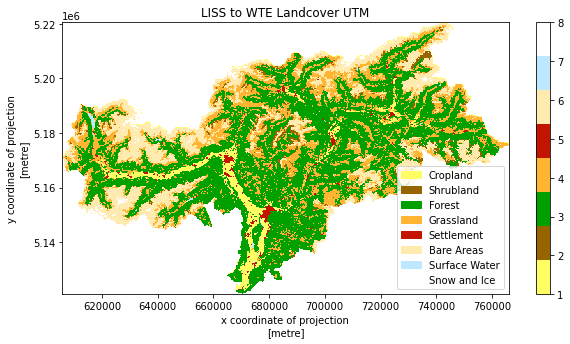

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
fig = liss_lc_clipped[0].plot.imshow(ax=ax,cmap=cmap_landcover,vmax=8, vmin=1)
ax.set_title("LISS to WTE Landcover UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [48]:
# liss_lc_clipped[0].to_netcdf("liss_lc_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [49]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lc_UTM),xr.ufuncs.isnan(liss_lc_clipped)))
wte_lc_UTM_masked_liss = wte_lc_UTM.where(na_mask)
liss_to_wte_UTM_masked = liss_lc_clipped.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [50]:
wte_liss_diff = wte_lc_UTM_masked_liss - liss_to_wte_UTM_masked

[]

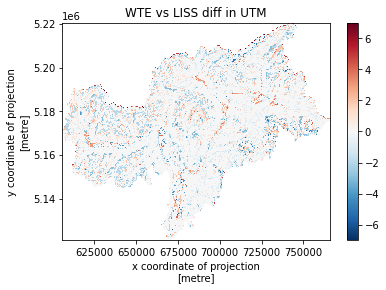

In [51]:
fig, ax = plt.subplots()
wte_liss_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs LISS diff in UTM")
plt.plot()

Compute the difference between the regional EURAC layer with the global ones

In [52]:
# #LISS vs CGLC:
# na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(liss_lc_clipped[0]),xr.ufuncs.isnan(cglc_landcover_clipped[0])))
# cglc_to_wte_UTM_masked = cglc_landcover_clipped[0].where(na_mask)
# liss_to_wte_UTM_masked = liss_lc_clipped.where(na_mask).drop('band')
# liss_cglc_diff = liss_to_wte_UTM_masked - cglc_to_wte_UTM_masked
# #LISS vs GLOBELAND:
# na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(liss_lc_clipped[0]),xr.ufuncs.isnan(globeland_lc_clipped[0])))
# globeland_to_wte_UTM_masked = globeland_lc_clipped[0].where(na_mask)
# liss_to_wte_UTM_masked  = liss_lc_clipped.where(na_mask).drop('band')
# liss_globeland_diff  = liss_to_wte_UTM_masked - globeland_to_wte_UTM_masked

Table resuming the correspondence between the data
1. Compute the number of pixels which are non zero
2. Compute the percentage and the area in km^2 of the difference

In [53]:
# #WTE vs CGLC:
# wte_cglc_diff_km2 = np.count_nonzero(wte_cglc_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
# wte_cglc_diff_dis = np.count_nonzero(wte_cglc_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_cglc_diff))*100 #Percentage of disagreement
# #WTE vs GLOBELAND:
# wte_globeland_diff_km2 = np.count_nonzero(wte_globeland_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
# wte_globeland_diff_dis = np.count_nonzero(wte_globeland_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_globeland_diff))*100 #Percentage of disagreement
# #WTE vs LISS:
# wte_liss_diff_km2 = np.count_nonzero(wte_liss_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
# wte_liss_diff_dis = np.count_nonzero(wte_liss_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_liss_diff))*100 #Percentage of disagreement
# #LISS vs CGLC:
# liss_cglc_diff_km2 = np.count_nonzero(liss_cglc_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
# liss_cglc_diff_dis = np.count_nonzero(liss_cglc_diff.fillna(0))/np.count_nonzero(~np.isnan(liss_cglc_diff))*100 #Percentage of disagreement
# #LISS vs GLOBELAND:
# liss_globeland_diff_km2 = np.count_nonzero(liss_globeland_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
# liss_globeland_diff_dis = np.count_nonzero(liss_globeland_diff.fillna(0))/np.count_nonzero(~np.isnan(liss_globeland_diff))*100 #Percentage of disagreement

In [54]:
# liss_cglc_diff[0].plot.imshow()

In [55]:
# import pandas as pd

# data = {'Disagreement [km^2]':  [wte_cglc_diff_km2, wte_globeland_diff_km2,wte_liss_diff_km2,liss_cglc_diff_km2,liss_globeland_diff_km2],
#         'Disagreement [%]': [wte_cglc_diff_dis, wte_globeland_diff_dis,wte_liss_diff_dis,liss_cglc_diff_dis,liss_globeland_diff_dis],
#         }

# df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'], index=['WTE vs CGLC','WTE vs GLOBELAND30','WTE vs LISS','LISS vs CGLC','LISS vs GLOBELAND'])

# df

In [56]:
def plot_confusion_matrix(ax, cm, labels, normalize=True, cmap='Blues',true="WTE",predicted="predicted"):
    """Plot the confusion matrix ``cm``.
    Parameters
    ----------
    cm : :py:class:`numpy.ndarray`
        The confusion matrix.
    labels : `list` [`str`]
        Names of the classes.
    normalize : `bool`, optional
        Whether to normalize the confusion matrix. The default is `True`.
    figsize : `tuple` [`int`], optional
        The figure size in centimeters. The default is `(10, 10)`.
    cmap : `str`, optional
        A matplotlib colormap. The default is `'Blues'`.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        An instance of :py:class:`matplotlib.figure.Figure`.
    ax : :py:class:`matplotlib.axes._subplots.AxesSubplot`
        An instance of :py:class:`matplotlib.axes._subplots.AxesSubplot`.
    """
    # number of classes
    nclasses = len(labels)

    # string format to plot values of confusion matrix
    fmt = '.0f'

    # minimum and maximum values of the colorbar
    vmin, vmax = 0, cm.max()

    # check whether to normalize the confusion matrix
    if normalize:
        # normalize
        norm = cm.sum(axis=1, keepdims=True)

        # check for division by zero
        norm[norm == 0] = 1
        cm = cm / norm

        # change string format to floating point
        fmt = '.2f'
        vmin, vmax = 0, 1

    # get colormap
    cmap = colormap.get_cmap(cmap, 256)

    # plot confusion matrix
    im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)

    # threshold determining the color of the values
    thresh = (cm.max() + cm.min()) / 2

    # brightest/darkest color of current colormap
    cmap_min, cmap_max = cmap(0), cmap(256)

    # plot values of confusion matrix
    for i, j in itertools.product(range(nclasses), range(nclasses)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=cmap_max if cm[i, j] < thresh else cmap_min)

    # axes properties and labels
    ax.set(xticks=np.arange(nclasses),yticks=np.arange(nclasses),xticklabels=labels,yticklabels=labels,ylabel=true,xlabel=predicted)

    # rotate x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    return


Define colors and labels for plotting:

In [57]:
colors_diff = ["#E0E0E0","#FFAA00"]
labels_diff = ["same","different"]
legend_diff = []
for i,x in enumerate(labels_diff):
    legend_diff.append(mpatches.Patch(color=colors_diff[i],label=x))

Create cmap for difference layer

In [58]:
diff_cmap = ListedColormap(["#E0E0E0","#FFAA00"])

[]

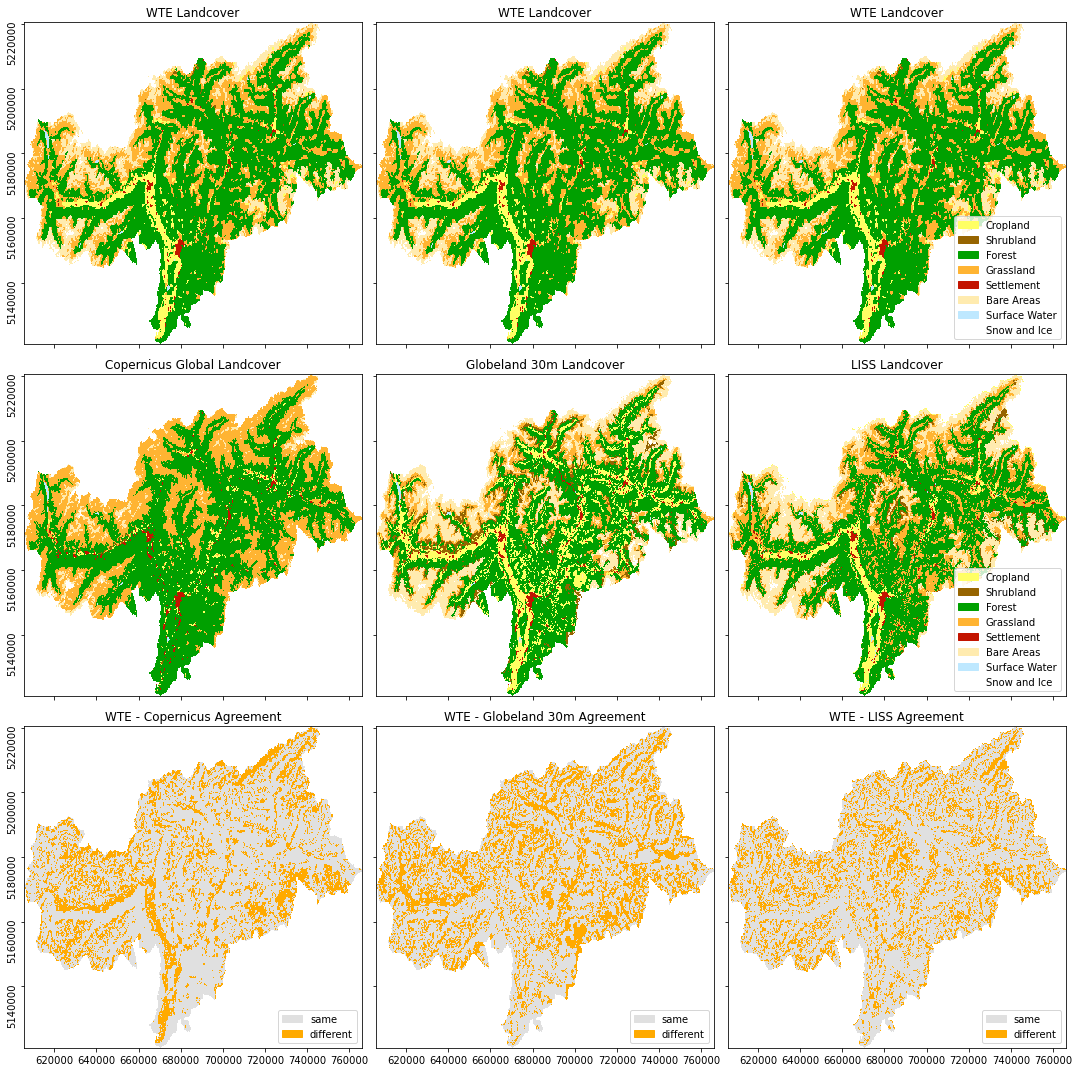

In [59]:
axis_xmin = wte_lc_UTM_masked_cglc.x.min().values
axis_ymin = wte_lc_UTM_masked_cglc.y.min().values
axis_xmax = wte_lc_UTM_masked_cglc.x.max().values
axis_ymax = wte_lc_UTM_masked_cglc.y.max().values

landcover_labels     = ['Cropland','Shrubland','Forest','Grassland','Settlement','Bare Areas','Surface Water','Snow and Ice']

fig, ax = plt.subplots(3,3,figsize=(15,15))
fig = wte_lc_UTM_masked_cglc[0].plot.imshow(ax=ax[0,0],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[0,0].set_title("WTE Landcover")
# ax[0,0].legend(handles=legend,loc='lower right')
fig = wte_lc_UTM_masked_globeland[0].plot.imshow(ax=ax[0,1],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[0,1].set_title("WTE Landcover")
# ax[0,1].legend(handles=legend,loc='lower right')
fig = wte_lc_UTM_masked_liss[0].plot.imshow(ax=ax[0,2],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[0,2].set_title("WTE Landcover")
ax[0,2].legend(handles=legend,loc='lower right')#,bbox_to_anchor=(1.35,0), frameon=True)

fig = cglc_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,0],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[1,0].set_title("Copernicus Global Landcover")
# ax[1,0].legend(handles=legend,loc='lower right')
fig = globeland_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,1],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[1,1].set_title("Globeland 30m Landcover")
# ax[1,1].legend(handles=legend,loc='lower right')
fig = liss_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,2],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[1,2].set_title("LISS Landcover")
ax[1,2].legend(handles=legend,loc='lower right')

na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_cglc_diff[0]))
wte_cglc_diff_masked = (abs(wte_cglc_diff[0])>0)
wte_cglc_diff_masked = wte_cglc_diff_masked.where(na_mask)

fig = wte_cglc_diff_masked.plot.imshow(ax=ax[2,0],cmap=diff_cmap,add_colorbar=False)#,cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,0].set_title("WTE - Copernicus Agreement")
ax[2,0].legend(handles=legend_diff,loc='lower right')

na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_globeland_diff[0]))
wte_globeland_diff_masked = (abs(wte_globeland_diff[0])>0)
wte_globeland_diff_masked = wte_globeland_diff_masked.where(na_mask)

fig = wte_globeland_diff_masked.plot.imshow(ax=ax[2,1],cmap=diff_cmap,add_colorbar=False)#,cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,1].set_title("WTE - Globeland 30m Agreement")
ax[2,1].legend(handles=legend_diff,loc='lower right')

na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_liss_diff[0]))
wte_liss_diff_masked = (abs(wte_liss_diff[0])>0)
wte_liss_diff_masked = wte_liss_diff_masked.where(na_mask)

fig = wte_liss_diff_masked.plot.imshow(ax=ax[2,2],cmap=diff_cmap,add_colorbar=False)#,cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,2].set_title("WTE - LISS Agreement")
ax[2,2].legend(handles=legend_diff,loc='lower right')
        
# rotate y-tick labels
for i in ax[:3]:
    for k in i[:]:
        for label in k.get_yticklabels():
            label.set_rotation(90)
    
# remove all axis labels
for i in ax[:3]:
    for k in i[:]:
        k.set_xlabel("")
        k.set_ylabel("")  
        k.ticklabel_format(style='plain')
for i in ax[:2]:
    for k in i[:]:
        for i, tick in enumerate(k.xaxis.get_ticklabels()):
            tick.set_visible(False)
for i in ax[:]:
    for k in i[1:]:
        for i, tick in enumerate(k.yaxis.get_ticklabels()):
            tick.set_visible(False)

plt.tight_layout()
plt.plot()

In [60]:
na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_cglc_diff[0]))
wte_cglc_diff_masked = (abs(wte_cglc_diff[0])>0)
wte_cglc_diff_masked = wte_cglc_diff_masked.where(na_mask)

[]

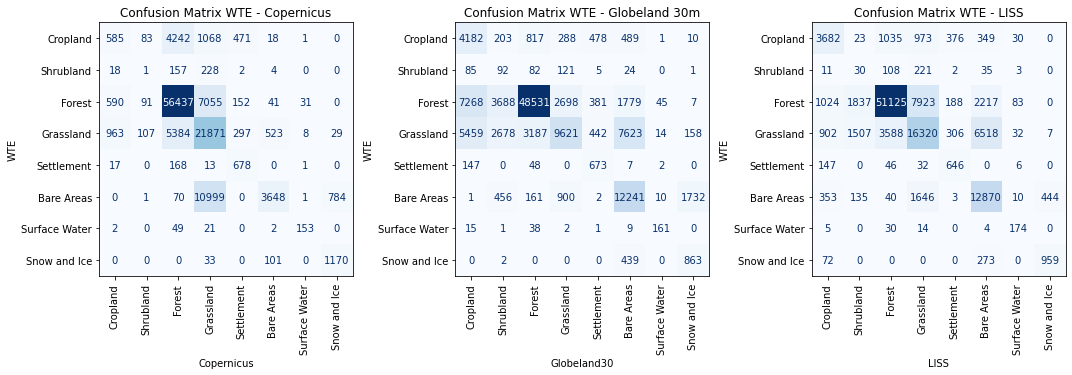

In [61]:
landcover_labels     = ['Cropland','Shrubland','Forest','Grassland','Settlement','Bare Areas','Surface Water','Snow and Ice']

fig, ax = plt.subplots(1,3,figsize=(15,20))
 
cm_cglc = confusion_matrix(wte_lc_UTM_masked_cglc[0].fillna(-999).values.flatten(), cglc_to_wte_UTM_masked[0].fillna(-999).values.flatten(), labels=[-999,1,2,3,4,5,6,7,8])
cm_cglc = cm_cglc[1:,1:]
plot_confusion_matrix(ax[0],cm_cglc,[1,2,3,4,5,6,7,8],true="WTE",predicted="Copernicus",normalize=None)
ax[0].set_xticklabels(landcover_labels)
ax[0].set_yticklabels(landcover_labels)
ax[0].set_title("Confusion Matrix WTE - Copernicus")

cm_glob = confusion_matrix(wte_lc_UTM_masked_globeland[0].fillna(-999).values.flatten(), globeland_to_wte_UTM_masked[0].fillna(-999).values.flatten(), labels=[-999,1,2,3,4,5,6,7,8])
cm_glob = cm_glob[1:,1:]
plot_confusion_matrix(ax[1],cm_glob,[1,2,3,4,5,6,7,8],true="WTE",predicted="Globeland30",normalize=None)
ax[1].set_xticklabels(landcover_labels)
ax[1].set_yticklabels(landcover_labels)
ax[1].set_title("Confusion Matrix WTE - Globeland 30m")

cm_liss = confusion_matrix(wte_lc_UTM_masked_liss.fillna(-999).values.flatten(), liss_to_wte_UTM_masked.fillna(-999).values.flatten(), labels=[-999,1,2,3,4,5,6,7,8])
cm_liss = cm_liss[1:,1:]
plot_confusion_matrix(ax[2],cm_liss,[1,2,3,4,5,6,7,8],true="WTE",predicted="LISS",normalize=None)
ax[2].set_xticklabels(landcover_labels)
ax[2].set_yticklabels(landcover_labels)
ax[2].set_title("Confusion Matrix WTE - LISS")

plt.tight_layout()
plt.plot()